# classification : 分類問題

# Preparation

## Preparation of google drive (if required)

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch220301/MiniCTorch_Prototype/notebook"

import sys
sys.path.append("../")

/content/drive/My Drive/Colab Notebooks/ctorch220301/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 31.3 MB/s 


In [ ]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

# Target Python Program

In [5]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

## データ読み込み

In [7]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


## ニューラルネットワークの定義

In [8]:
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [9]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

In [10]:
! mkdir -p classification

## 計算グラフをJSONファイルに出力する

In [11]:
def generate_json( json_path, input, target ):
    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )
    return model

In [12]:
torch.manual_seed( 1 )

batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]
inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

torch.Size([112, 4])
torch.Size([112])
create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [13]:
minictorch.convert_all( project, folder, model, json_path, inputs, {"input_data":x_train, "target_data":y_train}, sol="classification", batch=batch_size, shuffle=1 )

[JSON] ./classification/clas.json
param: xin  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
param: fc1_weight  - str loop  31  /  31
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
param: fc1_bias  - str loop  7  /  7
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
param: fc2_weight  - str loop  23  /  23
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
param: fc2_bias  - str loop  0  /  0
{'name': 'Model/Loss[loss]/60', 'op': 'prim::Constant', 'in': [], 'output_id': 0, 'shape': [16], 'constant_value': [2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0], 'out': [13], 

In [14]:
#check code
with torch.set_grad_enabled(True):
  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.1141, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 0.0051,  0.0076, -0.0039,  0.0055],
        [ 0.0032,  0.0070, -0.0009,  0.0063],
        [ 0.0075,  0.0023, -0.0018,  0.0030],
        [-0.0148, -0.0060,  0.0116, -0.0026],
        [ 0.0039,  0.0075, -0.0049,  0.0060],
        [ 0.0078,  0.0019, -0.0074,  0.0033],
        [ 0.0064,  0.0035, -0.0004,  0.0025],
        [ 0.0098,  0.0057, -0.0057,  0.0040],
        [-0.0094,  0.0001,  0.0001,  0.0019],
        [ 0.0071,  0.0055, -0.0062,  0.0067],
        [-0.0082, -0.0028,  0.0023, -0.0034],
        [ 0.0031,  0.0068, -0.0004,  0.0055],
        [ 0.0051,  0.0015, -0.0082,  0.0016],
        [ 0.0078,  0.0058, -0.0109,  0.0047],
        [ 0.0019, -0.0052,  0.0032, -0.0090],
        [-0.0014, -0.0045, -0.0031, -0.0079]])
Train Loss 1: 1.1141 Acc: 0.3750


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

# コンパイル

In [15]:
C_SRC = './classification/clas.cpp ./classification/clas_param.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include'
C_OUT = './classification/clas'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas.cpp ./classification/clas_param.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas


In [16]:
!./classification/clas

### forward computation ...
 1.114132
### backward computation ...
input_grad{{ 0.005121,  0.007634, -0.00392 ,  0.005463},
 { 0.003237,  0.007025, -0.000903,  0.006273},
 { 0.007456,  0.002275, -0.001825,  0.00303 },
 {-0.014833, -0.005986,  0.011635, -0.002603},
 { 0.003881,  0.007467, -0.004902,  0.006035},
 { 0.007827,  0.001859, -0.007408,  0.003304},
 { 0.006394,  0.003495, -0.000374,  0.002508},
 { 0.009828,  0.005667, -0.005712,  0.004038},
 {-0.009425,  0.000133,  0.000134,  0.001898},
 { 0.007134,  0.005511, -0.006214,  0.006686},
 {-0.008223, -0.002783,  0.002316, -0.003416},
 { 0.00309 ,  0.006757, -0.000382,  0.005532},
 { 0.005136,  0.001542, -0.008211,  0.001647},
 { 0.007821,  0.005842, -0.010921,  0.004711},
 { 0.001864, -0.005156,  0.003216, -0.009019},
 {-0.001419, -0.004502, -0.003072, -0.007932}}


# Python 学習コード

In [17]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += float(loss);

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.5509 Acc: 0.2054 23
Train Loss 1: 6.6930 Acc: 0.4107 46
Train Loss 2: 6.0455 Acc: 0.6607 74
Train Loss 3: 5.5601 Acc: 0.6875 77
Train Loss 4: 5.1895 Acc: 0.6964 78
Train Loss 5: 4.8852 Acc: 0.7143 80
Train Loss 6: 4.6443 Acc: 0.7321 82
Train Loss 7: 4.4512 Acc: 0.7589 85
Train Loss 8: 4.2780 Acc: 0.7857 88
Train Loss 9: 4.1271 Acc: 0.7768 87
Train Loss 10: 3.9962 Acc: 0.7768 87
Train Loss 11: 3.8764 Acc: 0.7857 88
Train Loss 12: 3.7703 Acc: 0.8125 91
Train Loss 13: 3.6740 Acc: 0.8125 91
Train Loss 14: 3.5854 Acc: 0.8036 90
Train Loss 15: 3.5081 Acc: 0.8125 91
Train Loss 16: 3.4295 Acc: 0.8214 92
Train Loss 17: 3.3565 Acc: 0.8304 93
Train Loss 18: 3.2935 Acc: 0.8304 93
Train Loss 19: 3.2338 Acc: 0.8304 93
Train Loss 20: 3.1739 Acc: 0.8482 95
Train Loss 21: 3.1198 Acc: 0.8571 96
Train Loss 22: 3.0715 Acc: 0.8482 95
Train Loss 23: 3.0219 Acc: 0.8571 96
Train Loss 24: 2.9740 Acc: 0.8750 98
Train Loss 25: 2.9302 Acc: 0.8750

収束状況グラフを描画する

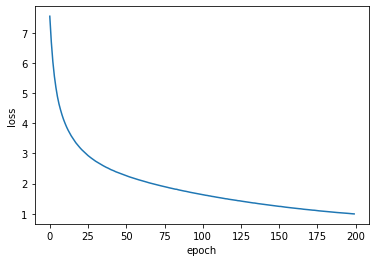

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

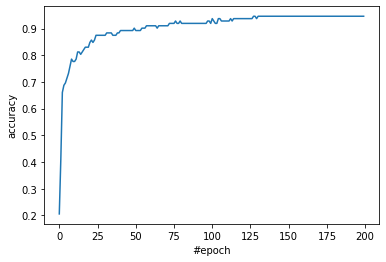

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

# C++ 学習コード

学習用C++コードをコンパイル、リンクする

In [20]:
C_SRC = './classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp'
C_OPT = '-I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp
OPT = -I ../src -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas_train


In [21]:
! ./classification/clas_train

epoch_num : 200
batch  number  : 7,16
learning ratio : 0.01
total_loss (batch): epoch 0 : loss 7.57026 : Acc 0.196429 22
total_loss (all)  : epoch 0 : loss 1.00031 : Acc 0.232143 26
total_loss (batch): epoch 1 : loss 6.68619 : Acc 0.410714 46
total_loss (all)  : epoch 1 : loss 0.896857 : Acc 0.598214 67
total_loss (batch): epoch 2 : loss 6.04703 : Acc 0.660714 74
total_loss (all)  : epoch 2 : loss 0.8193 : Acc 0.660714 74
total_loss (batch): epoch 3 : loss 5.55727 : Acc 0.669643 75
total_loss (all)  : epoch 3 : loss 0.760104 : Acc 0.678571 76
total_loss (batch): epoch 4 : loss 5.18315 : Acc 0.705357 79
total_loss (all)  : epoch 4 : loss 0.713754 : Acc 0.714286 80
total_loss (batch): epoch 5 : loss 4.88705 : Acc 0.714286 80
total_loss (all)  : epoch 5 : loss 0.676699 : Acc 0.732143 82
total_loss (batch): epoch 6 : loss 4.64768 : Acc 0.758929 85
total_loss (all)  : epoch 6 : loss 0.645785 : Acc 0.758929 85
total_loss (batch): epoch 7 : loss 4.4506 : Acc 0.758929 85
total_loss (all)  : ep

In [22]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("[OUT]",path)
print("epoch =", len(loss))
print( loss )
print(acc)

[OUT] ./classification/clas.out
epoch = 200
[1.000312, 0.896857, 0.8193, 0.760104, 0.713754, 0.676699, 0.645785, 0.619746, 0.59731, 0.577568, 0.559983, 0.544211, 0.529882, 0.516774, 0.504728, 0.493613, 0.483306, 0.473685, 0.464689, 0.45626, 0.44832, 0.440851, 0.43381, 0.427132, 0.420801, 0.41478, 0.409051, 0.403594, 0.398372, 0.393386, 0.388594, 0.384016, 0.379607, 0.375368, 0.371289, 0.367343, 0.363546, 0.359873, 0.356326, 0.352896, 0.349568, 0.346345, 0.343213, 0.340162, 0.337202, 0.334323, 0.331514, 0.328782, 0.326112, 0.323508, 0.320959, 0.318468, 0.316029, 0.313641, 0.311286, 0.308974, 0.306702, 0.304471, 0.302278, 0.300122, 0.298004, 0.295921, 0.293874, 0.291858, 0.289873, 0.287917, 0.285987, 0.28408, 0.282202, 0.280348, 0.278519, 0.276714, 0.27493, 0.273168, 0.271428, 0.269706, 0.268009, 0.266331, 0.264674, 0.263034, 0.261411, 0.25981, 0.258227, 0.256663, 0.255115, 0.25357, 0.252037, 0.250517, 0.249012, 0.247522, 0.246049, 0.244589, 0.24314, 0.241707, 0.240287, 0.238881, 0.23748

収束状況グラフを描画する

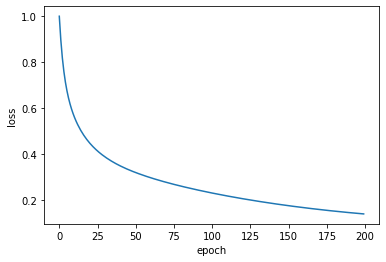

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

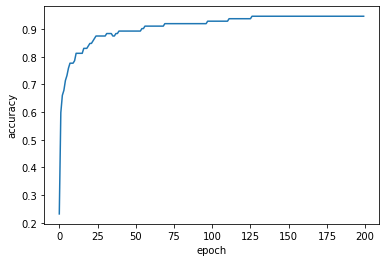

In [24]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()